In [1]:
# Import necessary libraries
import numpy as np
import polars as pl
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt

In [2]:
# Import data using Polars
train_df = pl.read_csv(
    source = "data/training_set_VU_DM.csv",
    null_values=["null", "NaN", "NULL"]
    )

# Print basic information about the data
print(train_df.head())
print(train_df.shape)

shape: (5, 54)
┌─────────┬────────────┬─────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ srch_id ┆ date_time  ┆ site_id ┆ visitor_lo ┆ … ┆ comp8_rate ┆ click_boo ┆ gross_boo ┆ booking_b │
│ ---     ┆ ---        ┆ ---     ┆ cation_cou ┆   ┆ _percent_d ┆ l         ┆ kings_usd ┆ ool       │
│ i64     ┆ str        ┆ i64     ┆ ntry_id    ┆   ┆ iff        ┆ ---       ┆ ---       ┆ ---       │
│         ┆            ┆         ┆ ---        ┆   ┆ ---        ┆ i64       ┆ f64       ┆ i64       │
│         ┆            ┆         ┆ i64        ┆   ┆ i64        ┆           ┆           ┆           │
╞═════════╪════════════╪═════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 1       ┆ 2013-04-04 ┆ 12      ┆ 187        ┆ … ┆ null       ┆ 0         ┆ null      ┆ 0         │
│         ┆ 08:32:15   ┆         ┆            ┆   ┆            ┆           ┆           ┆           │
│ 1       ┆ 2013-04-04 ┆ 12      ┆ 187        ┆ … ┆ null       ┆ 0         ┆

In [3]:
# We note that the data contains 3 buckets of information:
# 1) Customer information 
# 2) Property information 
# 3) Search information
# X) Competitor information

def get_columns(df: pl.DataFrame) -> dict:
    visitor_cols = [col for col in df.columns if "visitor_" in col]
    
    search_cols = [col for col in df.columns if any(substr in col for substr in [
        "srch_", "search_", "day_of_week", "month", "date_time", "weekend", "holiday"
    ])]
    
    booking_cols = [col for col in df.columns if any(substr in col for substr in [
        "prop_", "price", "promotion", "position", "click_bool", "booking_bool"
    ]) and col not in search_cols]

    return {
        "visitor": visitor_cols,
        "search": search_cols,
        "booking": booking_cols
    }

# Get the columns for each category
columns = get_columns(train_df)
print("Visitor columns:", columns["visitor"])
print("Search columns:", columns["search"])
print("Booking columns:", columns["booking"])

Visitor columns: ['visitor_location_country_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd']
Search columns: ['srch_id', 'date_time', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'srch_query_affinity_score']
Booking columns: ['prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag', 'click_bool', 'booking_bool']


### (1.1) Clean Visitor Columns

In [4]:

# We first clean the visitor columns
train_df.select(
    columns["visitor"]
).describe()

def process_visitor_history(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        # Ensure correct data type
        pl.col("visitor_hist_starrating").cast(pl.Float64),
        pl.col("visitor_hist_adr_usd").cast(pl.Float64),

        # Binary flags for whether information is available
        pl.col("visitor_hist_starrating").is_not_null().cast(pl.Int8).alias("visitor_has_starrating_info"),
        pl.col("visitor_hist_adr_usd").is_not_null().cast(pl.Int8).alias("visitor_has_adr_info"),

        # Fill nulls with sentinel (-1) for dense model inputs
        pl.col("visitor_hist_starrating").fill_null(-1).alias("visitor_hist_starrating_dense").cast(pl.Float64),
        pl.col("visitor_hist_adr_usd").fill_null(-1).alias("visitor_hist_adr_usd_dense").cast(pl.Float64)
    ])

# Input visitor feature for the model 
# Now, models will learn that -1 means no information available
process_visitor_history(train_df).select(
    [
        "visitor_has_starrating_info",
        "visitor_has_adr_info",
        "visitor_hist_starrating_dense",
        "visitor_hist_adr_usd_dense"
    ]
).describe()

statistic,visitor_has_starrating_info,visitor_has_adr_info,visitor_hist_starrating_dense,visitor_hist_adr_usd_dense
str,f64,f64,f64,f64
"""count""",4.958347e6,4.958347e6,4.958347e6,4.958347e6
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",0.050796,0.051023,-0.7778,8.032165
"""std""",0.219582,0.220044,0.973122,45.872174
"""min""",0.0,0.0,-1.0,-1.0
"""25%""",0.0,0.0,-1.0,-1.0
"""50%""",0.0,0.0,-1.0,-1.0
"""75%""",0.0,0.0,-1.0,-1.0
"""max""",1.0,1.0,5.0,1958.7


In [5]:
def process_date_time(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns([
        # Parse date_time string into datetime format
        pl.col("date_time").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S").alias("parsed_date")
    ])
    
    df = df.with_columns([
        # Extract year, month, day, hour, and weekday from parsed date
        # Create a binary flag for weekend searches (Saturday and Sunday)
        pl.col("parsed_date").dt.year().alias("year"),
        pl.col("parsed_date").dt.month().alias("month"),
        pl.col("parsed_date").dt.day().alias("day"), 
        pl.col("parsed_date").dt.hour().alias("search_hour"),
        pl.col("parsed_date").dt.weekday().alias("day_of_week"),  
        pl.col("parsed_date").dt.weekday().is_in([6, 7]).cast(pl.Int8).alias("is_weekend_search"),
        (
            pl.col("parsed_date").dt.year().cast(pl.Utf8) + 
            pl.col("parsed_date").dt.month().cast(pl.Utf8).str.zfill(2)
        ).alias("year_month")
    ])
    
    return df


In [6]:
train_df = process_date_time(train_df)
train_df.select(["year", "month", "day_of_week", "is_weekend_search"]).describe()

statistic,year,month,day_of_week,is_weekend_search
str,f64,f64,f64,f64
"""count""",4.958347e6,4.958347e6,4.958347e6,4.958347e6
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",2012.803169,5.164621,3.824736,0.243891
"""std""",0.397603,3.492702,1.980819,0.429428
"""min""",2012.0,1.0,1.0,0.0
"""25%""",2013.0,3.0,2.0,0.0
"""50%""",2013.0,4.0,4.0,0.0
"""75%""",2013.0,6.0,5.0,0.0
"""max""",2013.0,12.0,7.0,1.0


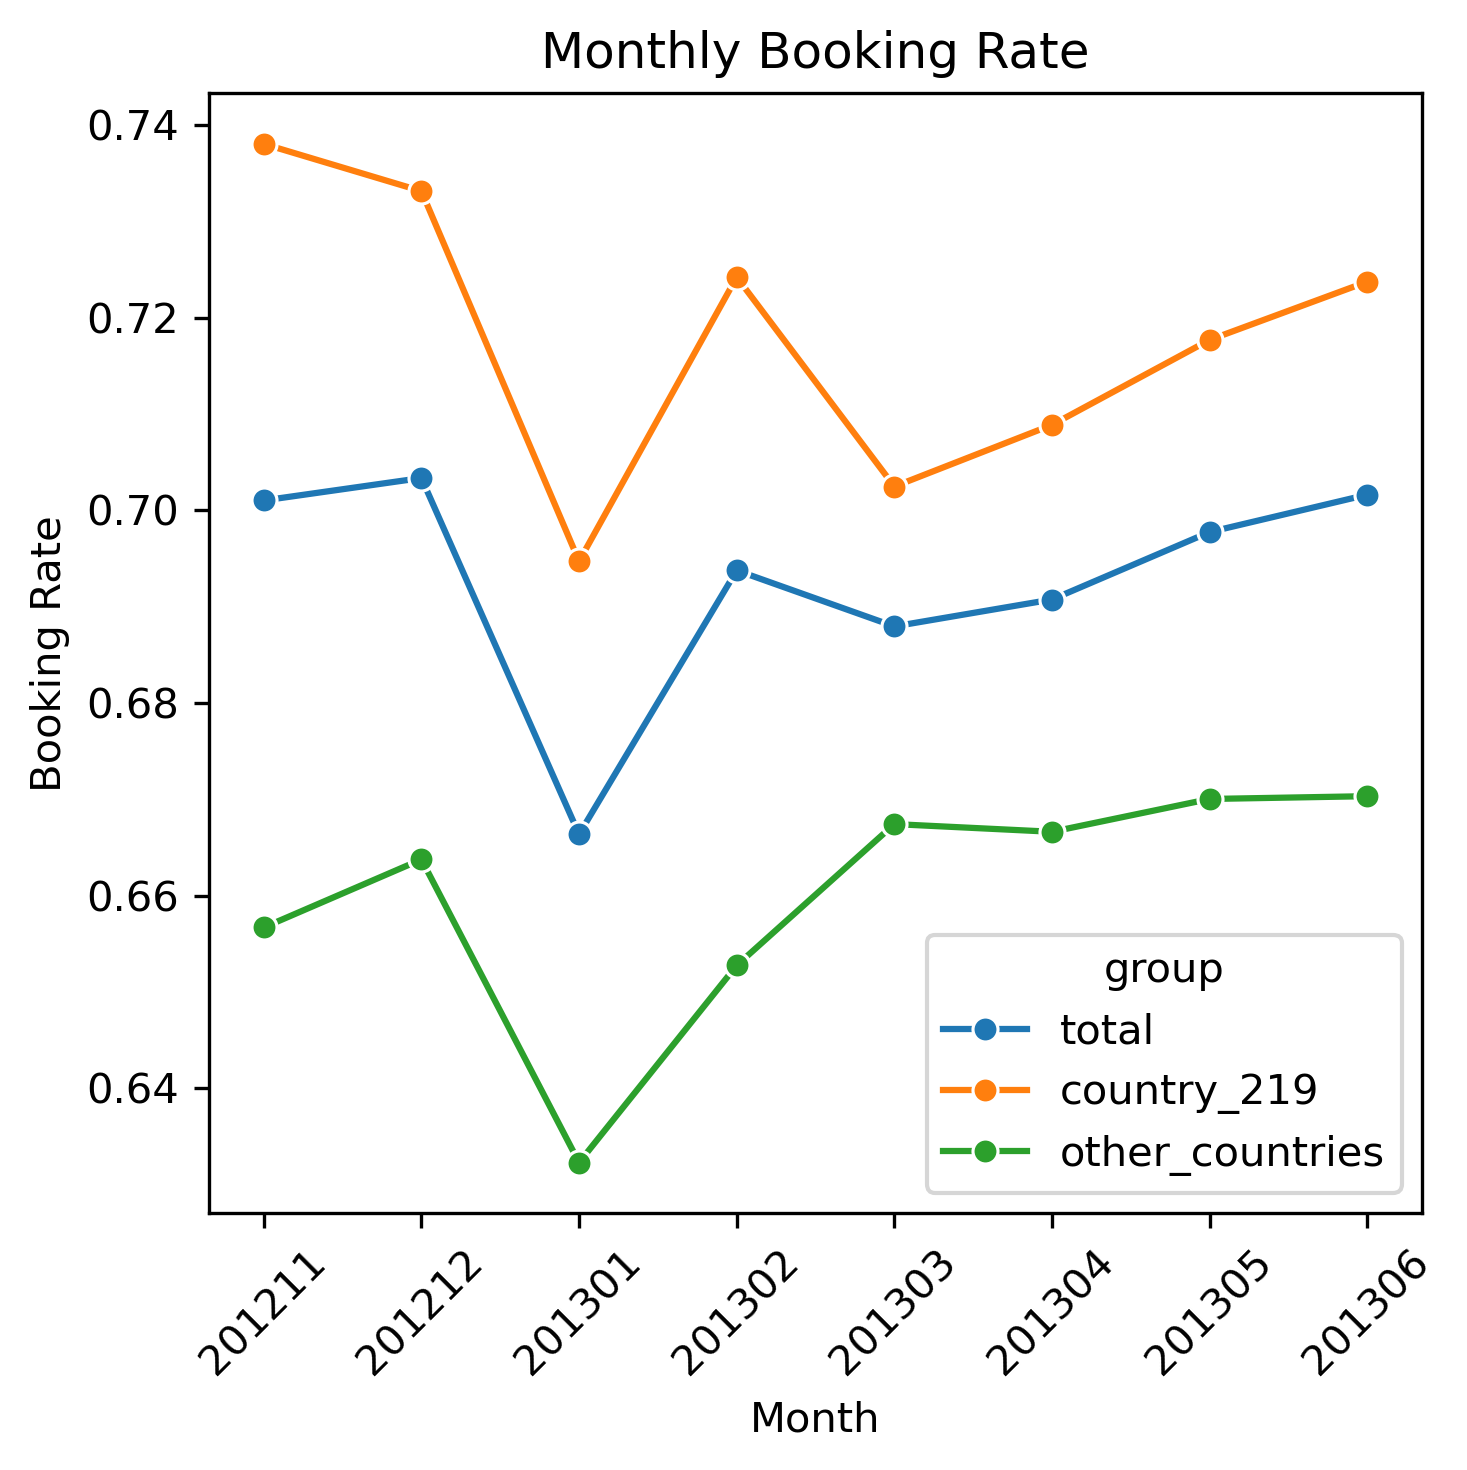

In [7]:
# The relationship between whether people will book a hotel depends on the month is affected by country_id=219
# https://ajourneyintodatascience.quora.com/Learning-to-Rank-Personalize-Expedia-Hotel-Searches-ICDM-2013-http-ajourneyintodatascience-ryin-main-quora-com-Le
# Let's verify this by plotting the booking rate over time and see if we can confirm this pattern

train_df = train_df.with_columns([
    # Let's see the overall pattern over linear time
    (pl.col("year").cast(pl.Utf8) + pl.col("month").cast(pl.Utf8).str.zfill(2)).alias("year_month"),
    pl.col("booking_bool").cast(pl.Int8)
])


def compute_booking_rate(df: pl.DataFrame, group_name: str) -> pl.DataFrame:
    return (
        df.group_by("year_month")
        .agg([
            pl.col("booking_bool").sum().alias("bookings"),
            pl.col("srch_id").n_unique().alias("searches")
        ])
        .with_columns([
            (pl.col("bookings") / pl.col("searches")).alias("booking_rate"),
            pl.lit(group_name).alias("group")
        ])
        .sort("year_month")
    )

# Compute booking rates and combine
total = compute_booking_rate(train_df, "total")
c219 = compute_booking_rate(train_df.filter(pl.col("visitor_location_country_id") == 219), "country_219")
others = compute_booking_rate(train_df.filter(pl.col("visitor_location_country_id") != 219), "other_countries")

df_plot = pl.concat([total, c219, others]).to_pandas()

# Plot
plt.figure(figsize=(5, 5), dpi=300)
sns.lineplot(data=df_plot, x="year_month", y="booking_rate", hue="group", marker="o")
plt.title("Monthly Booking Rate")
plt.xlabel("Month")
plt.ylabel("Booking Rate")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [8]:
# A clear cyclical pattern is present, so we transform our features to capture this better
# We will use sine and cosine transformations to encode cyclical features

def add_time_features(df: pl.DataFrame) -> pl.DataFrame:
    new_columns = []

    for col_name, period in [("month", 12), ("search_hour", 24), ("day_of_week", 7)]:
        new_columns.extend([
            pl.col(col_name).cast(pl.Float64).map_elements(
                lambda x: np.sin(2 * np.pi * x / period),
                return_dtype=pl.Float64
            ).alias(f"{col_name}_sin"),

            pl.col(col_name).cast(pl.Float64).map_elements(
                lambda x: np.cos(2 * np.pi * x / period),
                return_dtype=pl.Float64
            ).alias(f"{col_name}_cos")
        ])

    return df.with_columns(new_columns)


In [9]:
train_df = add_time_features(train_df)

In [32]:
### (1.2) Clean Search Columns
train_df.select(
    columns["search"]
).describe()

statistic,srch_id,date_time,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score
str,f64,str,f64,f64,f64,f64,f64,f64,f64,str
"""count""",4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,"""317406"""
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""4640941"""
"""mean""",166366.561096,null,14042.630393,2.385427,37.474165,1.972637,0.350492,1.110525,0.502213,null
"""std""",96112.230102,null,8111.843351,2.053243,51.993411,0.857063,0.732569,0.417229,0.499995,null
"""min""",1.0,"""2012-11-01 00:08:29""",2.0,1.0,0.0,1.0,0.0,1.0,0.0,"""-10"""
"""25%""",82936.0,null,7101.0,1.0,4.0,2.0,0.0,1.0,0.0,null
"""50%""",166507.0,null,13541.0,2.0,17.0,2.0,0.0,1.0,1.0,null
"""75%""",249724.0,null,21084.0,3.0,48.0,2.0,0.0,1.0,1.0,null
"""max""",332785.0,"""2013-06-30 23:58:24""",28416.0,57.0,492.0,9.0,9.0,8.0,1.0,"""-99"""


### (1.2) Clean Properties Columns

In [11]:
train_df.select(
    columns["booking"]
).describe()

statistic,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,click_bool,booking_bool
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4.958347e6,4.958347e6,4.958347e6,4.950983e6,4.958347e6,4.958347e6,3.867999e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6
"""null_count""",0.0,0.0,0.0,7364.0,0.0,0.0,1.090348e6,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",173.973897,70079.179496,3.180525,3.777777,0.634699,2.872589,0.130385,4.317913,16.856236,254.20959,0.21562,0.044749,0.027911
"""std""",68.345248,40609.920378,1.051024,1.050329,0.481514,1.531011,0.159463,1.834869,10.425655,16001.237061,0.411252,0.206751,0.164716
"""min""",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"""25%""",100.0,35010.0,3.0,3.5,0.0,1.79,0.019,4.45,8.0,85.0,0.0,0.0,0.0
"""50%""",219.0,69638.0,3.0,4.0,1.0,2.77,0.069,4.91,16.0,122.0,0.0,0.0,0.0
"""75%""",219.0,105168.0,4.0,4.5,1.0,4.04,0.1805,5.31,26.0,184.96,0.0,0.0,0.0
"""max""",230.0,140821.0,5.0,5.0,1.0,6.98,1.0,6.21,40.0,1.9726328e7,1.0,1.0,1.0


In [ ]:
# Prop_review_score is messy. So, we split the information into
train_df = train_df.with_columns([
    # Fill null with sentinel (-1), keep 0.0 as-is (means: no reviews)
    pl.col("prop_review_score").cast(pl.Float64).fill_null(-1.0).alias("prop_review_score_filled"),

    # Flag: is the score usable (non-null and > 0)?
    (pl.col("prop_review_score") > 0).cast(pl.Int8).alias("has_usable_review")
])



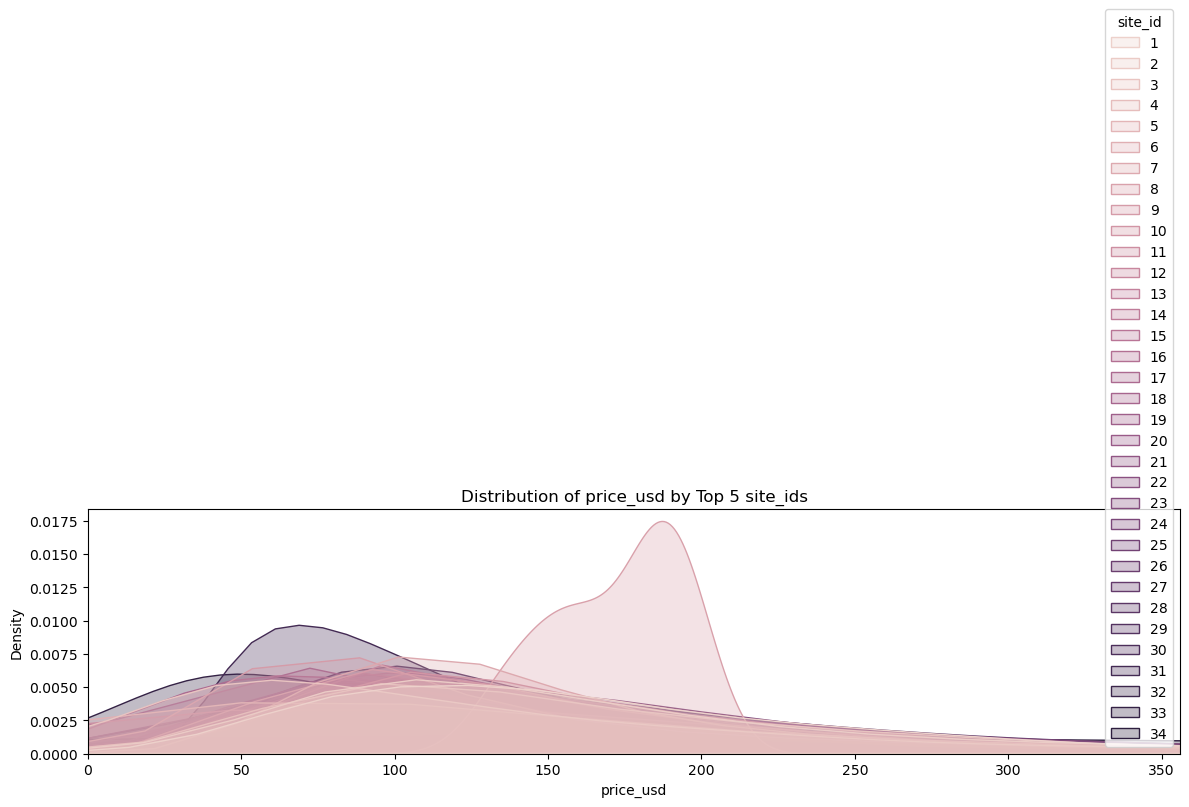

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=train_df, x="price_usd", hue="site_id", common_norm=False, fill=True, alpha=0.3)
plt.xlim(0, train_df["price_usd"].quantile(0.95))
plt.title("Distribution of price_usd by site_ids")
plt.xlabel("price_usd")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [30]:
df_pd = train_df.select([
    "site_id", 
    "price_usd", 
    "srch_length_of_stay"
]).with_columns([
    (pl.col("price_usd") / pl.col("srch_length_of_stay")).alias("price_per_night")
]).to_pandas()
# Group and compute descriptive statistics
desc_table = (
    df_pd.groupby("site_id")
    .agg(
        price_mean=("price_per_night", "mean"),
        price_median=("price_per_night", "median"),
        price_q10=("price_per_night", lambda x: x.quantile(0.10)),
        price_q25=("price_per_night", lambda x: x.quantile(0.25)),
        price_q75=("price_per_night", lambda x: x.quantile(0.75)),
        price_q90=("price_per_night", lambda x: x.quantile(0.90)),
        price_q95=("price_per_night", lambda x: x.quantile(0.95)),
        price_q99=("price_per_night", lambda x: x.quantile(0.99)),
    )
    .reset_index()
)

# Optional: sort by price_mean
desc_table = desc_table.sort_values(by="price_median", ascending=False)

# Display or export
print(desc_table)

    site_id  price_mean  price_median  price_q10  price_q25   price_q75  \
7         8   85.983871     89.500000  71.000000  78.250000   94.500000   
6         7  101.434658     84.820000  29.566667  50.110000  128.637500   
13       14  122.910120     78.875000  25.110429  44.430000  125.040000   
14       15  308.494671     75.050000  21.803333  40.200000  126.140833   
29       30   98.481882     74.303333  19.975800  38.386667  120.110000   
4         5  153.428034     74.000000  25.000000  42.833333  119.000000   
10       11   93.683519     71.041667  21.713333  39.287667  120.110000   
26       27   96.278935     70.136667  18.831250  35.427500  128.282500   
22       23   92.237543     67.265833  17.958833  35.615833  123.136250   
31       32  159.972179     66.860000  18.533250  34.966167  122.630000   
20       21   93.139545     66.650000  17.041107  33.297750  113.988750   
1         2   88.582593     65.970000  20.501397  35.572917  107.874375   
23       24   88.816915  

In [ ]:
def process_competitor_features(df: pl.DataFrame) -> pl.DataFrame:
    rate_cols = [f"comp{i}_rate" for i in range(1, 9)]
    inv_cols = [f"comp{i}_inv" for i in range(1, 9)]
    diff_cols = [f"comp{i}_rate_percent_diff" for i in range(1, 9)]

    # Cast and fill missing with 0
    for col in rate_cols + inv_cols + diff_cols:
        df = df.with_columns([
            pl.col(col).cast(pl.Float64).fill_null(0.0).alias(col)
        ])

    # Aggregation logic
    num_comps_lower = sum([pl.col(col) == 1 for col in rate_cols]).alias("num_comps_lower")
    num_comps_higher = sum([pl.col(col) == -1 for col in rate_cols]).alias("num_comps_higher")
    num_comps_with_inventory = sum([pl.col(col) == 1 for col in inv_cols]).alias("num_comps_with_inventory")

    # Mean of all percent diffs
    total_diff = reduce(lambda a, b: a + b, [pl.col(c) for c in diff_cols])
    count_diff = reduce(lambda a, b: a + b, [pl.col(c).is_not_null().cast(pl.Float64) for c in diff_cols])
    avg_diff = (total_diff / count_diff).alias("avg_comp_rate_percent_diff")

    # Mean when comp rate is lower
    lower_diffs = [
        pl.when(pl.col(r) == 1).then(pl.col(d)).otherwise(None)
        for r, d in zip(rate_cols, diff_cols)
    ]
    total_lower = reduce(lambda a, b: a + b, lower_diffs)
    count_lower = reduce(lambda a, b: a + b, [expr.is_not_null().cast(pl.Float64) for expr in lower_diffs])


    return df.with_columns([
        num_comps_lower,
        num_comps_higher,
        num_comps_with_inventory,
        avg_diff,   
    ])


def clean_competitor_columns(df: pl.DataFrame) -> pl.DataFrame:
    rate_cols = [f"comp{i}_rate" for i in range(1, 9)]
    inv_cols = [f"comp{i}_inv" for i in range(1, 9)]
    diff_cols = [f"comp{i}_rate_percent_diff" for i in range(1, 9)]
    all_comp_cols = rate_cols + inv_cols + diff_cols

    df = process_competitor_features(df)
    df = df.drop(all_comp_cols)

    return df


train_df = clean_competitor_columns(train_df)


In [83]:
train_df.describe()


statistic,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,parsed_date,year,month,day,search_hour,day_of_week,is_weekend_search,year_month,num_comps_lower,num_comps_higher,num_comps_with_inventory,avg_comp_rate_percent_diff,avg_diff_when_lower
str,f64,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""count""",4.958347e6,"""4958347""",4.958347e6,4.958347e6,"""251866""","""252988""",4.958347e6,4.958347e6,4.958347e6,4.950983e6,4.958347e6,4.958347e6,3.867999e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,"""317406""",3.350565e6,4.958347e6,4.958347e6,138390.0,4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,0.0
"""null_count""",0.0,"""0""",0.0,0.0,"""4706481""","""4705359""",0.0,0.0,0.0,7364.0,0.0,0.0,1.090348e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""4640941""",1.607782e6,0.0,0.0,4.819957e6,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,4.958347e6
"""mean""",166366.561096,null,9.953133,175.340453,null,null,173.973897,70079.179496,3.180525,3.777777,0.634699,2.872589,0.130385,4.317913,16.856236,254.20959,0.21562,14042.630393,2.385427,37.474165,1.972637,0.350492,1.110525,0.502213,null,1301.234406,0.2959,0.044749,386.283316,0.027911,"""2013-03-11 06:19:37.890843""",2012.803169,5.164621,15.662119,13.70044,3.824736,0.243891,null,0.233776,0.19768,0.105543,2.833073,null
"""std""",96112.230102,null,7.64689,65.916249,null,null,68.345248,40609.920378,1.051024,1.050329,0.481514,1.531011,0.159463,1.834869,10.425655,16001.237061,0.411252,8111.843351,2.053243,51.993411,0.857063,0.732569,0.417229,0.499995,null,2023.951353,0.456446,0.206751,821.190577,0.164716,null,0.397603,3.492702,8.681805,5.41967,1.980819,0.429428,null,0.624802,0.613191,0.374386,164.411784,null
"""min""",1.0,"""2012-11-01 00:08:29""",1.0,1.0,"""1""","""0""",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,"""-10""",0.01,0.0,0.0,0.0,0.0,"""2012-11-01 00:08:29""",2012.0,1.0,1.0,0.0,1.0,0.0,"""201211""",0.0,0.0,0.0,0.0,null
"""25%""",82936.0,null,5.0,100.0,null,null,100.0,35010.0,3.0,3.5,0.0,1.79,0.019,4.45,8.0,85.0,0.0,7101.0,1.0,4.0,2.0,0.0,1.0,0.0,null,139.8,0.0,0.0,124.0,0.0,"""2013-01-14 17:47:32""",2013.0,3.0,8.0,10.0,2.0,0.0,null,0.0,0.0,0.0,0.0,null
"""50%""",166507.0,null,5.0,219.0,null,null,219.0,69638.0,3.0,4.0,1.0,2.77,0.069,4.91,16.0,122.0,0.0,13541.0,2.0,17.0,2.0,0.0,1.0,1.0,null,386.6,0.0,0.0,218.4,0.0,"""2013-03-13 20:13:18""",2013.0,4.0,16.0,14.0,4.0,0.0,null,0.0,0.0,0.0,0.0,null
"""75%""",249724.0,null,14.0,219.0,null,null,219.0,105168.0,4.0,4.5,1.0,4.04,0.1805,5.31,26.0,184.96,0.0,21084.0,3.0,48.0,2.0,0.0,1.0,1.0,null,1500.67,1.0,0.0,429.79,0.0,"""2013-05-10 00:01:38""",2013.0,6.0,23.0,18.0,5.0,0.0,null,0.0,0.0,0.0,1.25,null
"""max""",332785.0,"""2013-06-30 23:58:24""",34.0,231.0,"""5""","""999""",230.0,140821.0,5.0,5.0,1.0,6.98,1.0,6.21,40.0,1.9726328e7,1.0,28416.0,57.0,492.0,9.0,9.0,8.0,1.0,"""-99""",11666.64,1.0,1.0,159292.38,1.0,"""2013-06-30 23:58:24""",2013.0,12.0,31.0,23.0,7.0,1.0,"""201306""",6.0,6.0,6.0,125198.0,null


In [37]:
train_df = train_df.with_columns([
    pl.col("srch_query_affinity_score").cast(pl.Float64)
])

# 2. Compute a fill_value slightly worse than observed minimum
min_score = train_df.select(pl.col("srch_query_affinity_score").min()).item()
fill_value = min_score - 0.5

# 3. Fill missing values and create missing indicator
train_df = train_df.with_columns([
    pl.col("srch_query_affinity_score").fill_null(fill_value).alias("query_affinity_score_cleaned"),
    pl.col("srch_query_affinity_score").is_null().cast(pl.Int8).alias("query_affinity_missing")
])

In [38]:
train_df.describe()

statistic,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,parsed_date,year,month,day,search_hour,day_of_week,is_weekend_search,year_month,month_sin,month_cos,search_hour_sin,search_hour_cos,day_of_week_sin,day_of_week_cos,prop_review_score_filled,has_usable_review,gross_per_night,price_diff,query_affinity_score_cleaned,query_affinity_missing
str,f64,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4.958347e6,"""4958347""",4.958347e6,4.958347e6,"""251866""","""252988""",4.958347e6,4.958347e6,4.958347e6,4.950983e6,4.958347e6,4.958347e6,3.867999e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,317406.0,3.350565e6,4.958347e6,"""119930""","""129559""","""94439""",2.024672e6,2.130269e6,556238.0,1.534288e6,1.65099e6,472797.0,"""307378""","""343663""","""131086""",2.222373e6,2.36002e6,841099.0,"""240157""","""260976""","""96174""","""315348""","""356422""","""138515""",1.916654e6,1.987503e6,614730.0,4.958347e6,138390.0,4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.950983e6,138390.0,138390.0,4.958347e6,4.958347e6
"""null_count""",0.0,"""0""",0.0,0.0,"""4706481""","""4705359""",0.0,0.0,0.0,7364.0,0.0,0.0,1.090348e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.640941e6,1.607782e6,0.0,"""4838417""","""4828788""","""4863908""",2.933675e6,2.828078e6,4.402109e6,3.424059e6,3.307357e6,4.48555e6,"""4650969""","""4614684""","""4827261""",2.735974e6,2.598327e6,4.117248e6,"""4718190""","""4697371""","""4862173""","""4642999""","""4601925""","""4819832""",3.041693e6,2.970844e6,4.343617e6,0.0,4.819957e6,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,7364.0,4.819957e6,4.819957e6,0.0,0.0
"""mean""",166366.561096,null,9.953133,175.340453,null,null,173.973897,70079.179496,3.180525,3.777777,0.634699,2.872589,0.130385,4.317913,16.856236,254.20959,0.21562,14042.630393,2.385427,37.474165,1.972637,0.350492,1.110525,0.502213,-24.146418,1301.234406,0.2959,null,null,null,0.04419,0.03931,18.490732,0.01729,0.057769,27.071559,null,null,null,0.022676,0.051429,29.851903,null,null,null,null,null,null,-0.060899,0.009963,22.430384,0.044749,386.283316,0.027911,"""2013-03-11 06:19:37.890843""",2012.803169,5.164621,15.662119,13.70044,3.824736,0.243891,null,-0.173963,-0.2448,0.010852,0.042348,0.055352,-0.043996,3.770681,0.952879,174.122889,86.391181,-307.676165,0.935986
"""std""",96112.230102,null,7.64689,65.916249,null,null,68.345248,40609.920378,1.051024,1.050329,0.481514,1.531011,0.159463,1.834869,10.425655,16001.237061,0.411252,8111.843351,2.053243,51.993411,0.857063,0.732569,0.417229,0.499995,15.743238,2023.951353,0.456446,null,null,null,0.448424,0.234239,240.113851,0.457581,0.29482,1012.919911,null,null,null,0.521757,0.267836,1340.262382,null,null,null,null,null,null

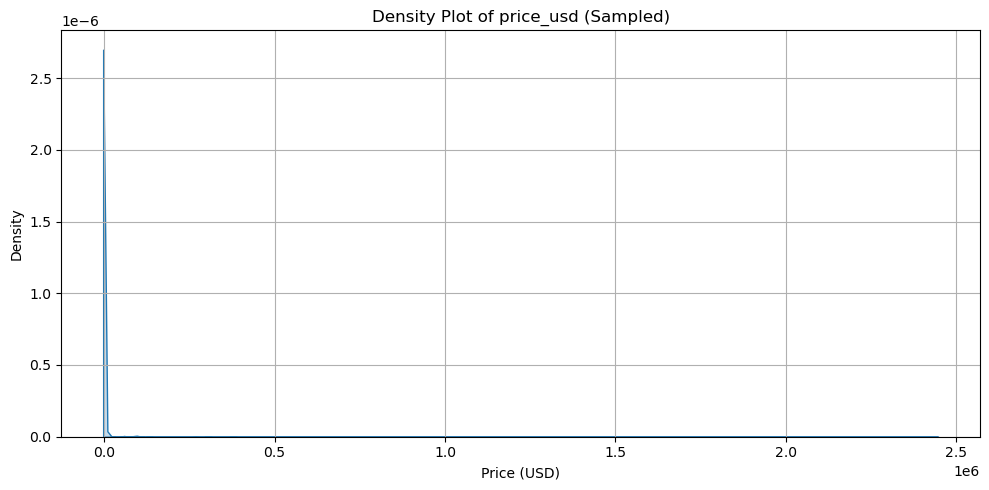

In [ ]:
# Clean price
sampled_df = train_df.sample(n=100_000, with_replacement=False, shuffle=True)

plt.figure(figsize=(10, 5))
sns.kdeplot(sampled_df['price_usd'], fill=True)
plt.title("Density Plot of price_usd (Sampled)")
plt.xlabel("Price (USD)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

